In [1]:
import os
import sys
import pickle
import argparse
from scipy import sparse
import numpy as np
import rpy2.robjects as robjects

script_dir = "../"
sys.path.append(os.path.abspath(script_dir))
from file2 import *
from factorize import *
from smallsim_functions import simulate_multinomial_counts
from misc import *

## SLA

In [2]:
datafile="../../ebpmf_data_analysis/output/fastTopics_fit/fit_sla_fastTopics_k6.Rds"
vocabfile="../../ebpmf_data_analysis/data/SLA/vocab.sla.txt"
titlefile="../../ebpmf_data_analysis/data/SLA/title.sla.txt"

readRDS = robjects.r['readRDS']
data = readRDS(datafile)
F = np.asarray(data.rx2('F'))
L = np.asarray(data.rx2('L'))
s = np.asarray(data.rx2('s'))
del data

for i in range(F.shape[1]):
    n_anchor = find_anchor_word_k(F, i).sum()
    print(f"topic {i}: {n_anchor} anchor words")

vocab = np.loadtxt(vocabfile, delimiter="\n", dtype = "str")
title = np.loadtxt(titlefile, delimiter="\n", dtype = "str")

topic 0: 565 anchor words
topic 1: 429 anchor words
topic 2: 287 anchor words
topic 3: 468 anchor words
topic 4: 838 anchor words
topic 5: 803 anchor words


In [3]:
p, k = F.shape
n, _ = L.shape

C = F @ L.T
C = C @ C.T / n
Cbar = C / C.sum(axis = 1)[:, None]

In [4]:
%%capture
S0, B0, A0, _, _, _, _, _ = factorizeC(C, K=k, rectifier='no', optimizer='activeSet')
Cbar = pca_proj(Cbar)

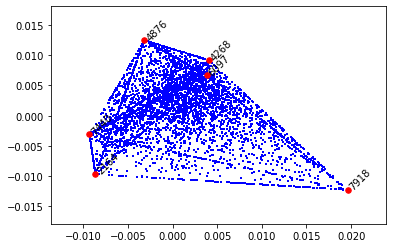

[(4876, 'misspecification'),
 (7918, 'test'),
 (6097, 'priors'),
 (2164, 'disease'),
 (4268, 'lasso'),
 (7440, 'spatial')]

In [5]:
which_dim = [0, 1]
vis_extremal_pca(Cbar, S0, which_dim = which_dim, annotate=True,fontsize=10)
[(w, vocab[w]) for w in S0]

In [6]:
find_anchor_word_k(F, i)

array([[ True],
       [False],
       [False],
       ...,
       [False],
       [False],
       [False]])

### Look at all the anchor words

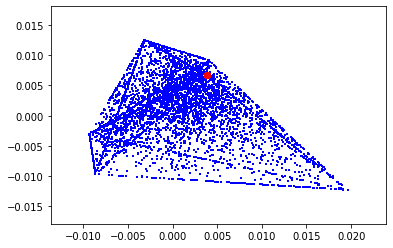

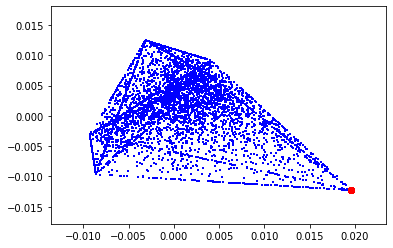

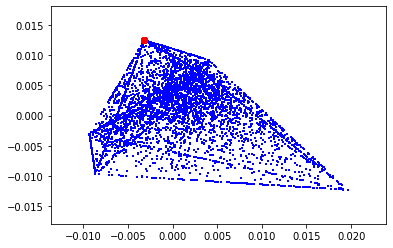

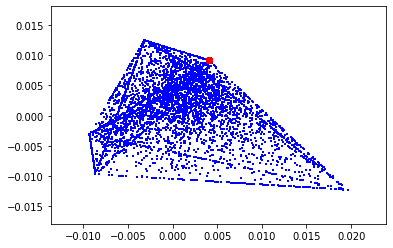

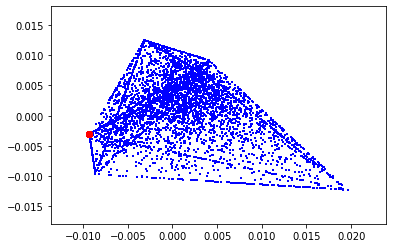

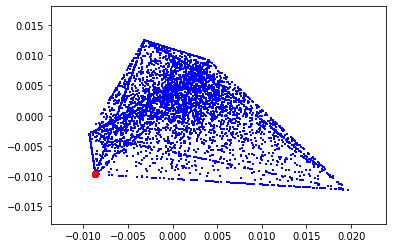

In [7]:
for i in range(F.shape[1]):
    ind = np.where(find_anchor_word_k(F, i) == True)[0].tolist()
    vis_extremal_pca(Cbar, ind, which_dim = [0, 1], annotate=False,fontsize=0)


In [8]:
tpx_idx = match_topics(F, B0).astype(int)

In [9]:
for i in range(k):
    print(f"############ topic {i}")
    print(vocab[S0[tpx_idx[i]]])
    idx = np.argsort(F[:, i])[-10:]
    print(vocab[idx])
    idx = np.argsort(L[:, i])[-10:]
    print(L[idx,i])
    print(title[idx])

############ topic 0
priors
['posterior' 'random' 'process' 'bayesian' 'prior' 'density' 'model'
 'distributions' 'distribution' 'models']
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
['Evaluation of formal posterior distributions via {M}arkov chain arguments'
 'On identification of multi-factor models with correlated residuals'
 'Consistency of {M}arkov chain quasi-{M}onte {C}arlo on continuous state spaces'
 'Efficient recursions for general factorisable models'
 'A {M}onte {C}arlo method for computing the marginal likelihood in nondecomposable {G}aussian graphical models'
 'Saddlepoint approximation for moment generating functions of truncated random variables'
 'Enriched conjugate and reference priors for the {W}ishart family on symmetric cones'
 'Identifiability of parameters in latent structure models with many observed variables'
 "Geometric ergodicity of van {D}yk and {M}eng's algorithm for the multivariate {S}tudent's {$t$} model"
 'Wishart distributions for decomposable graphs']
#########

## NIPS

topic 0: 641 anchor words
topic 1: 369 anchor words
topic 2: 463 anchor words
topic 3: 389 anchor words
[inference.findS] Start finding the set of anchor bases S...
+ Finish finding set S!
  - Discovered 4 basis vectors by [sparsePartial] method.
  - Elapsed time = 2.9715 seconds

[[0.       0.       0.       0.000495]
 [0.       0.006829 0.       0.      ]
 [0.000428 0.       0.       0.      ]
 [0.       0.       0.000203 0.      ]]


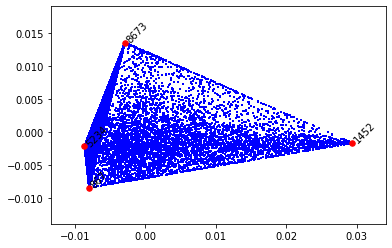

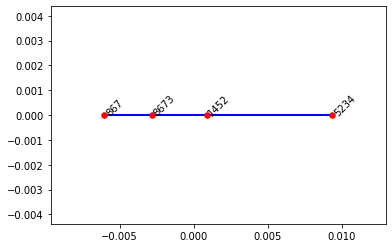

look at all anchor words


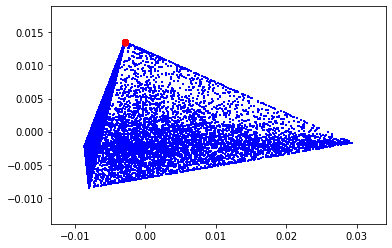

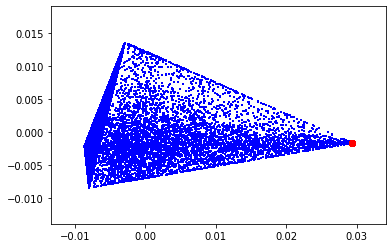

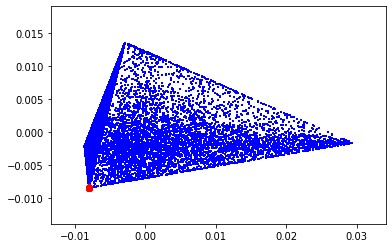

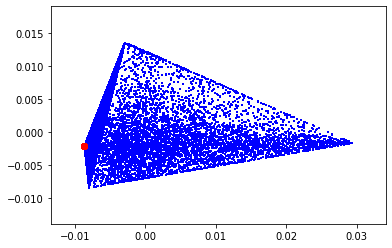

In [10]:
dataname="nips"
datadir=f"../../../gdrive/github_data/fastTopics-experiments-data/output/{dataname}/rds"
modelname=f"fit-{dataname}-scd-ex-k=4.rds"

readRDS = robjects.r['readRDS']
data = readRDS(f"{datadir}/{modelname}")
fit = data.rx2('fit')

L = np.asarray(fit.rx2('L'))
F = np.asarray(fit.rx2('F'))
F, L = poisson2multinom(F, L)

for i in range(F.shape[1]):
    n_anchor = find_anchor_word_k(F, i).sum()
    print(f"topic {i}: {n_anchor} anchor words")

n, k = L.shape
p, _ = F.shape

C = L @ F.T
C = (C.T @ C) / n

Cbar = C / C.sum(axis = 1)[:, None]

# S0, B0, A0, _, _, _, _, _ = factorizeC(C, K=k, rectifier='no', optimizer='activeSet')
S0, _, _ = findS(Cbar, k)
print(F[S0,:].round(6))

Cbar = pca_proj(Cbar)
vis_extremal_pca(Cbar, S0, which_dim = [0, 1], annotate=True,fontsize=10)
vis_extremal_pca(Cbar, S0, which_dim = [2, 3], annotate=True,fontsize=10)

print("look at all anchor words")
for i in range(F.shape[1]):
    ind = np.where(find_anchor_word_k(F, i) == True)[0].tolist()
    vis_extremal_pca(Cbar, ind, which_dim = [0, 1], annotate=False,fontsize=0)


topic 0: 44 anchor words
topic 1: 150 anchor words
topic 2: 515 anchor words
topic 3: 62 anchor words
topic 4: 273 anchor words
topic 5: 233 anchor words
[inference.findS] Start finding the set of anchor bases S...
+ Finish finding set S!
  - Discovered 6 basis vectors by [sparsePartial] method.
  - Elapsed time = 4.2923 seconds

[[0.       0.000297 0.       0.       0.       0.      ]
 [0.       0.       0.       0.000164 0.       0.      ]
 [0.       0.       0.0005   0.       0.       0.      ]
 [0.000222 0.       0.       0.       0.       0.      ]
 [0.       0.       0.       0.       0.000331 0.      ]
 [0.       0.       0.       0.       0.       0.000465]]


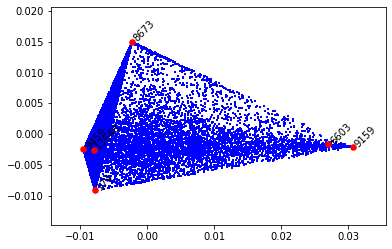

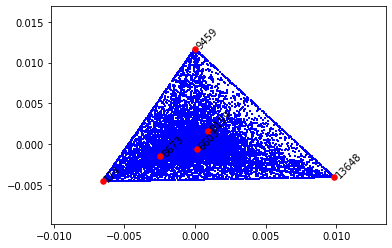

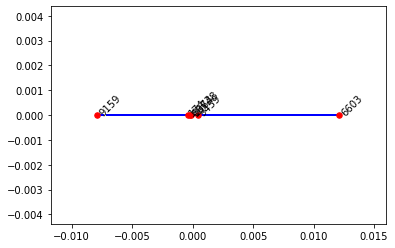

look at all anchor words


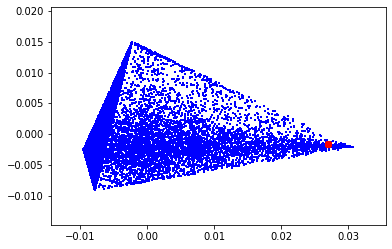

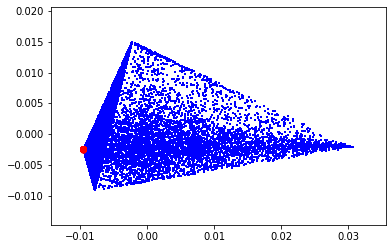

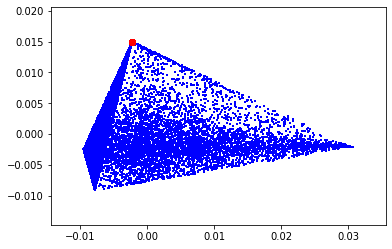

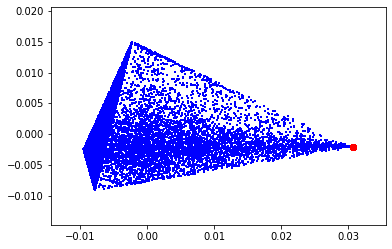

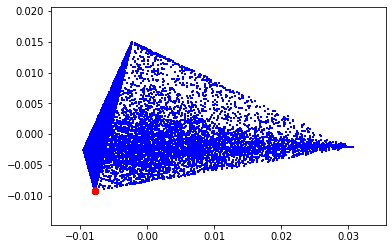

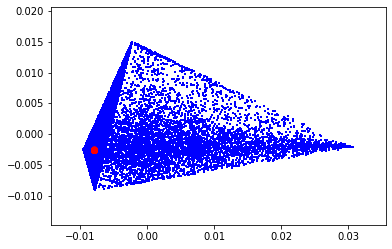

In [11]:
dataname="nips"
datadir=f"../../../gdrive/github_data/fastTopics-experiments-data/output/{dataname}/rds"
modelname=f"fit-{dataname}-scd-ex-k=6.rds"

readRDS = robjects.r['readRDS']
data = readRDS(f"{datadir}/{modelname}")
fit = data.rx2('fit')

L = np.asarray(fit.rx2('L'))
F = np.asarray(fit.rx2('F'))
F, L = poisson2multinom(F, L)

for i in range(F.shape[1]):
    n_anchor = find_anchor_word_k(F, i).sum()
    print(f"topic {i}: {n_anchor} anchor words")

n, k = L.shape
p, _ = F.shape

C = L @ F.T
C = (C.T @ C) / n

Cbar = C / C.sum(axis = 1)[:, None]

# S0, B0, A0, _, _, _, _, _ = factorizeC(C, K=k, rectifier='no', optimizer='activeSet')
S0, _, _ = findS(Cbar, k)
print(F[S0,:].round(6))

Cbar = pca_proj(Cbar)
vis_extremal_pca(Cbar, S0, which_dim = [0, 1], annotate=True,fontsize=10)
vis_extremal_pca(Cbar, S0, which_dim = [2, 3], annotate=True,fontsize=10)
vis_extremal_pca(Cbar, S0, which_dim = [4, 5], annotate=True,fontsize=10)

print("look at all anchor words")
for i in range(F.shape[1]):
    ind = np.where(find_anchor_word_k(F, i) == True)[0].tolist()
    vis_extremal_pca(Cbar, ind, which_dim = [0, 1], annotate=False,fontsize=0)


topic 0: 14 anchor words
topic 1: 5 anchor words
topic 2: 336 anchor words
topic 3: 64 anchor words
topic 4: 14 anchor words
topic 5: 154 anchor words
topic 6: 94 anchor words
topic 7: 109 anchor words
topic 8: 82 anchor words
topic 9: 11 anchor words
[inference.findS] Start finding the set of anchor bases S...
+ Finish finding set S!
  - Discovered 10 basis vectors by [sparsePartial] method.
  - Elapsed time = 7.0481 seconds

[[0.       0.       0.       0.       0.       0.       0.       0.
  0.000334 0.      ]
 [0.       0.       0.       0.       0.000116 0.       0.       0.
  0.       0.      ]
 [0.000148 0.       0.       0.       0.       0.       0.       0.
  0.       0.      ]
 [0.       0.       0.       0.000588 0.       0.       0.       0.
  0.       0.      ]
 [0.       0.       0.000683 0.       0.       0.       0.       0.
  0.       0.      ]
 [0.       0.000259 0.       0.       0.       0.       0.       0.
  0.       0.      ]
 [0.       0.       0.       0.    

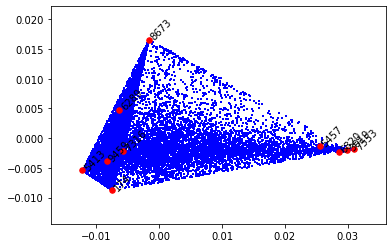

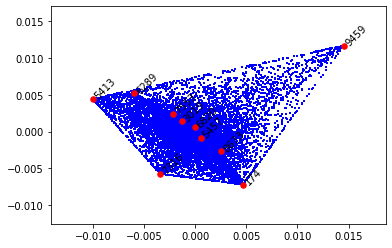

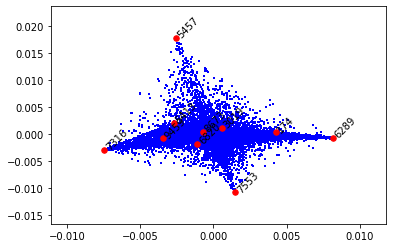

look at all anchor words


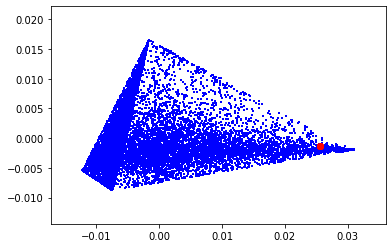

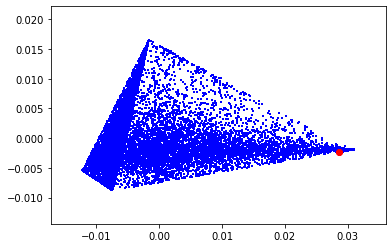

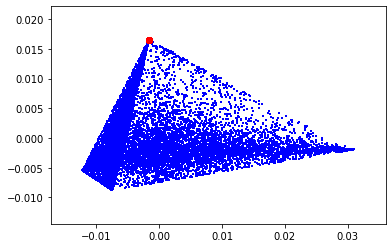

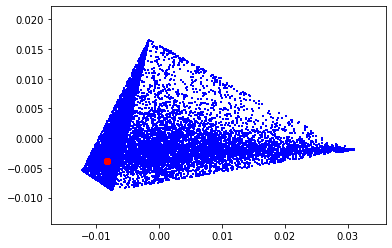

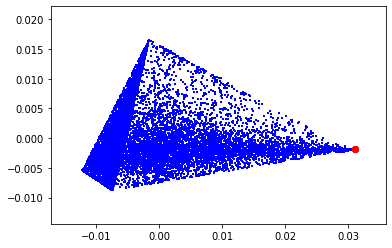

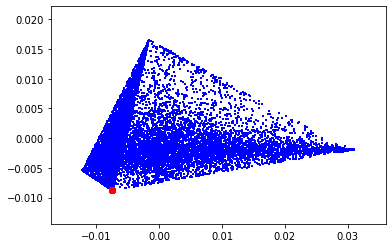

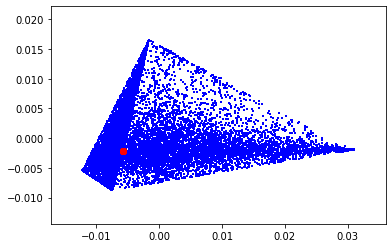

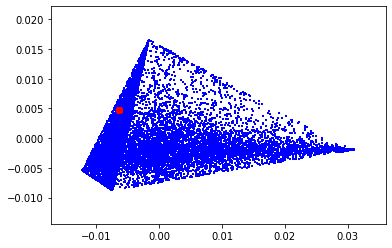

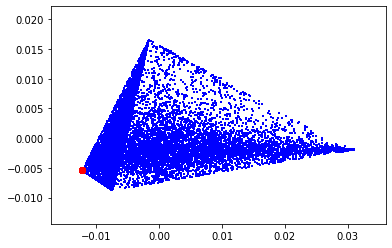

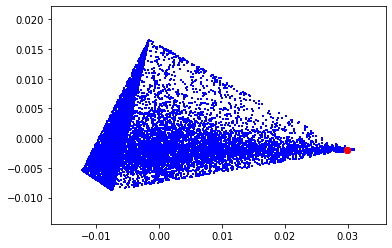

In [12]:
dataname="nips"
datadir=f"../../../gdrive/github_data/fastTopics-experiments-data/output/{dataname}/rds"
modelname=f"fit-{dataname}-scd-ex-k=10.rds"

readRDS = robjects.r['readRDS']
data = readRDS(f"{datadir}/{modelname}")
fit = data.rx2('fit')

L = np.asarray(fit.rx2('L'))
F = np.asarray(fit.rx2('F'))
F, L = poisson2multinom(F, L)

for i in range(F.shape[1]):
    n_anchor = find_anchor_word_k(F, i).sum()
    print(f"topic {i}: {n_anchor} anchor words")

n, k = L.shape
p, _ = F.shape

C = L @ F.T
C = (C.T @ C) / n

Cbar = C / C.sum(axis = 1)[:, None]

# S0, B0, A0, _, _, _, _, _ = factorizeC(C, K=k, rectifier='no', optimizer='activeSet')
S0, _, _ = findS(Cbar, k)
print(F[S0,:].round(6))

Cbar = pca_proj(Cbar)
vis_extremal_pca(Cbar, S0, which_dim = [0, 1], annotate=True,fontsize=10)
vis_extremal_pca(Cbar, S0, which_dim = [2, 3], annotate=True,fontsize=10)
vis_extremal_pca(Cbar, S0, which_dim = [4, 5], annotate=True,fontsize=10)

print("look at all anchor words")
for i in range(F.shape[1]):
    ind = np.where(find_anchor_word_k(F, i) == True)[0].tolist()
    vis_extremal_pca(Cbar, ind, which_dim = [0, 1], annotate=False,fontsize=0)


## pbmc68

In [13]:
dataname="pbmc68k"
datadir=f"../../../gdrive/github_data/fastTopics-experiments-data/output/{dataname}/rds"
modelname=f"fit-{dataname}-scd-ex-k=4.rds"

readRDS = robjects.r['readRDS']
data = readRDS(f"{datadir}/{modelname}")
fit = data.rx2('fit')

L = np.asarray(fit.rx2('L'))
F = np.asarray(fit.rx2('F'))
del data, fit

F, L = poisson2multinom(F, L)

for i in range(F.shape[1]):
    n_anchor = find_anchor_word_k(F, i).sum()
    print(f"topic {i}: {n_anchor} anchor words")
    

topic 0: 61 anchor words
topic 1: 23 anchor words
topic 2: 40 anchor words
topic 3: 265 anchor words


In [14]:
dataname="pbmc68k"
datadir=f"../../../gdrive/github_data/fastTopics-experiments-data/output/{dataname}/rds"
modelname=f"fit-{dataname}-scd-ex-k=7.rds"

readRDS = robjects.r['readRDS']
data = readRDS(f"{datadir}/{modelname}")
fit = data.rx2('fit')

L = np.asarray(fit.rx2('L'))
F = np.asarray(fit.rx2('F'))
del data, fit

F, L = poisson2multinom(F, L)

for i in range(F.shape[1]):
    n_anchor = find_anchor_word_k(F, i).sum()
    print(f"topic {i}: {n_anchor} anchor words")
    

topic 0: 139 anchor words
topic 1: 339 anchor words
topic 2: 33 anchor words
topic 3: 7 anchor words
topic 4: 77 anchor words
topic 5: 0 anchor words
topic 6: 7 anchor words


In [15]:
dataname="pbmc68k"
datadir=f"../../../gdrive/github_data/fastTopics-experiments-data/output/{dataname}/rds"
modelname=f"fit-{dataname}-scd-ex-k=12.rds"

readRDS = robjects.r['readRDS']
data = readRDS(f"{datadir}/{modelname}")
fit = data.rx2('fit')

L = np.asarray(fit.rx2('L'))
F = np.asarray(fit.rx2('F'))
del data, fit

F, L = poisson2multinom(F, L)

for i in range(F.shape[1]):
    n_anchor = find_anchor_word_k(F, i).sum()
    print(f"topic {i}: {n_anchor} anchor words")
    

topic 0: 53 anchor words
topic 1: 5 anchor words
topic 2: 224 anchor words
topic 3: 0 anchor words
topic 4: 3 anchor words
topic 5: 0 anchor words
topic 6: 18 anchor words
topic 7: 7 anchor words
topic 8: 27 anchor words
topic 9: 5 anchor words
topic 10: 15 anchor words
topic 11: 20 anchor words


## droplet

In [16]:
dataname="droplet"
datadir=f"../../../gdrive/github_data/fastTopics-experiments-data/output/{dataname}/rds"
modelname=f"fit-{dataname}-scd-ex-k=4.rds"

readRDS = robjects.r['readRDS']
data = readRDS(f"{datadir}/{modelname}")
fit = data.rx2('fit')

L = np.asarray(fit.rx2('L'))
F = np.asarray(fit.rx2('F'))
del data, fit

F, L = poisson2multinom(F, L)

for i in range(F.shape[1]):
    n_anchor = find_anchor_word_k(F, i).sum()
    print(f"topic {i}: {n_anchor} anchor words")
    

topic 0: 6 anchor words
topic 1: 3 anchor words
topic 2: 0 anchor words
topic 3: 100 anchor words


In [17]:
dataname="droplet"
datadir=f"../../../gdrive/github_data/fastTopics-experiments-data/output/{dataname}/rds"
modelname=f"fit-{dataname}-scd-ex-k=6.rds"

readRDS = robjects.r['readRDS']
data = readRDS(f"{datadir}/{modelname}")
fit = data.rx2('fit')

L = np.asarray(fit.rx2('L'))
F = np.asarray(fit.rx2('F'))
del data, fit

F, L = poisson2multinom(F, L)

for i in range(F.shape[1]):
    n_anchor = find_anchor_word_k(F, i).sum()
    print(f"topic {i}: {n_anchor} anchor words")
    

topic 0: 3 anchor words
topic 1: 0 anchor words
topic 2: 98 anchor words
topic 3: 11 anchor words
topic 4: 0 anchor words
topic 5: 5 anchor words


In [18]:
dataname="droplet"
datadir=f"../../../gdrive/github_data/fastTopics-experiments-data/output/{dataname}/rds"
modelname=f"fit-{dataname}-scd-ex-k=12.rds"

readRDS = robjects.r['readRDS']
data = readRDS(f"{datadir}/{modelname}")
fit = data.rx2('fit')

L = np.asarray(fit.rx2('L'))
F = np.asarray(fit.rx2('F'))
del data, fit

F, L = poisson2multinom(F, L)

for i in range(F.shape[1]):
    n_anchor = find_anchor_word_k(F, i).sum()
    print(f"topic {i}: {n_anchor} anchor words")
    

topic 0: 9 anchor words
topic 1: 13 anchor words
topic 2: 82 anchor words
topic 3: 5 anchor words
topic 4: 0 anchor words
topic 5: 11 anchor words
topic 6: 0 anchor words
topic 7: 5 anchor words
topic 8: 0 anchor words
topic 9: 0 anchor words
topic 10: 0 anchor words
topic 11: 0 anchor words
